In [529]:
import copy
import functools
import os

from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

import jax
import optax
import numpy as np
import tensorflow as tf

from acme import specs
from acme.tf.savers import SaveableAdapter

import contrastive
from contrastive.config import ContrastiveConfig
from contrastive import utils as contrastive_utils
from contrastive import make_networks
from contrastive.utils import make_environment
from contrastive import ContrastiveLearner
from contrastive.builder import create_maze_dataset_iterator
from tqdm import tqdm
import point_env
import ant_env
# disable tensorflow_probability warning: The use of `check_types` is deprecated and does not have any effect.
import logging
logger = logging.getLogger("root")

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()

logger.addFilter(CheckTypesFilter())

In [530]:
def getConfig(env_name, ckpt_dir, ckpt_num=None):
    params = {
      'use_random_actor': True,
      'entropy_coefficient': None if 'image' in env_name else 0.0,
      'env_name': env_name,
      # For online RL experiments, max_number_of_steps is the number of
      # environment steps. For offline RL experiments, this is the number of
      # gradient steps.
      'max_number_of_steps': 1_000_000,
      'use_image_obs': 'image' in env_name,
    }
    if 'ant_' in env_name:
        params['end_index'] = 2

    # 2. Select an algorithm. The currently-supported algorithms are:
    # contrastive_nce, contrastive_cpc, c_learning, nce+c_learning, gcbc.
    # Many other algorithms can be implemented by passing other parameters
    # or adding a few lines of code.
    alg = 'contrastive_nce'
    if alg == 'contrastive_nce':
        pass  # Just use the default hyperparameters
    elif alg == 'contrastive_cpc':
        params['use_cpc'] = True
    elif alg == 'c_learning':
        params['use_td'] = True
        params['twin_q'] = True
    elif alg == 'nce+c_learning':
        params['use_td'] = True
        params['twin_q'] = True
        params['add_mc_to_td'] = True
    elif alg == 'gcbc':
        params['use_gcbc'] = True
    else:
        raise NotImplementedError('Unknown method: %s' % alg)
        
    if 'ant_' in env_name:
        params['end_index'] = 2
        maze = None
        if 'ant_umaze' in env_name:
            maze = ant_env.U_MAZE
        elif 'ant_medium' in env_name:
            maze = ant_env.BIG_MAZE
        else:
            maze = ant_env.HARDEST_MAZE

        params['maze_shape'] = tuple(np.array(maze).shape)

    if 'point_' in env_name:
        name = env_name[6:]
        maze = point_env.WALLS[name]
        params['maze_shape'] = tuple(np.array(maze).shape)
        
    if env_name.startswith('point'):
        params['scaling_factor'] = 1.
    else:
        print(f'scaling factor set to 4.')
        params['scaling_factor'] = 4.

    # For the offline RL experiments, modify some hyperparameters.
    if env_name.startswith('offline_ant'):
        params.update({
            # Effectively remove the rate-limiter by using very large values.
            'samples_per_insert': 1_000_000,
            'samples_per_insert_tolerance_rate': 100_000_000.0,
            # For the actor update, only use future states as goals.
            'random_goals': 0.0,
            'bc_coef': 0.05,  # Add a behavioral cloning term to the actor.
            'twin_q': True,  # Learn two critics, and take the minimum.
            'batch_size': 1024,  # Increase the batch size 256 --> 1024.
            'repr_dim': 16,  # Decrease the representation size 64 --> 16.
            # Increase the policy network size (256, 256) --> (1024, 1024)
            'hidden_layer_sizes': (1024, 1024),
        })
        print('hi')
        
    config = ContrastiveConfig(**params)
    config.critic_learning_rate = 0.001
    obs_dim = make_environment(env_name, config.start_index, config.end_index, seed=0)[1]
    print(config.maze_shape)
    network_factory = functools.partial(
      contrastive.make_networks, 
        obs_dim=obs_dim, 
        repr_dim=config.repr_dim,
      repr_norm=config.repr_norm, 
        twin_q=config.twin_q,
      use_image_obs=config.use_image_obs,
      hidden_layer_sizes=config.hidden_layer_sizes,
      maze_shape=config.maze_shape
    )

    env_factory = lambda seed: make_environment(
      env_name, config.start_index, config.end_index, seed)[0]
    dummy_seed = 1
    environment_spec = specs.make_environment_spec(
        env_factory(dummy_seed))
    random_key = jax.random.PRNGKey(np.random.choice(int(1e6)))
    networks = network_factory(environment_spec)
    policy_optimizer = optax.adam(
      learning_rate=config.actor_learning_rate)
    q_optimizer = optax.adam(
      learning_rate=config.critic_learning_rate)
    l_optimizer = optax.adam(
        learning_rate=config.critic_learning_rate
    )

    trained_learner = ContrastiveLearner(
      networks=networks,
      rng=random_key,
      policy_optimizer=policy_optimizer,
      q_optimizer=q_optimizer,
      l_optimizer=l_optimizer,
      iterator=None,
      counter=None,
      logger=None,
      config=config,
      obs_to_goal=None,
      l_iterator=None
    )

    ckpt = tf.train.Checkpoint(learner=SaveableAdapter(trained_learner))
    ckpt_mgr = tf.train.CheckpointManager(
        ckpt, ckpt_dir, 1)
    
    if ckpt_num:
        ckpt.restore(os.path.join(ckpt_dir, f'ckpt-{ckpt_num}'))
    else:
        ckpt.restore(ckpt_mgr.latest_checkpoint)

    trained_learner_state = trained_learner._state

    print("Model loaded from: {}".format(ckpt_dir))

    return config, trained_learner, env_factory, networks, environment_spec

In [583]:
env_name = "ant_umaze"
ckpt_dir = "/home/yongweic/acme/9e6e3f8a-4a25-11ef-abe0-70b5e8f00aac/checkpoints/learner"

# env_name = 'point_FourRooms'
# ckpt_dir = '/home/yongweic/acme/f0beb494-49ef-11ef-a142-70b5e8f06ca6/checkpoints/learner'

config, trained_learner, env_factory, networks, env_spec = getConfig(env_name, ckpt_dir, ckpt_num=34)
iterator = create_maze_dataset_iterator(config)
trained_learner_state = trained_learner._state

scaling_factor = config.scaling_factor
sf = int(scaling_factor)
maze_shape = (config.maze_shape)

print(scaling_factor)

scaling factor set to 4.
Target Goal:  (5.021817427036397, 9.267891617973081)
(5, 5)
Target Goal:  (9.061247034903547, 9.432077617000731)
maze_shape: (5, 5)
q_params: dict_keys(['sa_encoder/~/linear_0', 'sa_encoder/~/linear_1', 'sa_encoder/~/linear_2', 'g_encoder/~/linear_0', 'g_encoder/~/linear_1', 'g_encoder/~/linear_2'])
l_params: dict_keys(['g_encoder/~/linear_0', 'g_encoder/~/linear_1', 'g_encoder/~/linear_2', 'l_encoder/~/linear_0', 'l_encoder/~/linear_1', 'l_encoder/~/linear_2'])
merged_params: dict_keys(['g_encoder/~/linear_0', 'g_encoder/~/linear_1', 'g_encoder/~/linear_2', 'sa_encoder/~/linear_0', 'sa_encoder/~/linear_1', 'sa_encoder/~/linear_2', 'l_encoder/~/linear_0', 'l_encoder/~/linear_1', 'l_encoder/~/linear_2'])
Model loaded from: /home/yongweic/acme/9e6e3f8a-4a25-11ef-abe0-70b5e8f00aac/checkpoints/learner
4.0


In [584]:
# example usage
env = env_factory(np.random.randint(1e6))
action_dim = env.action_space.shape[0]
obs = env.reset().observation[None,:]
print(obs.shape)
obs_dim = obs.shape[1]
print(f'cur: {obs[:,:2]}, goal: {obs[:,-2:]}')

q_params = trained_learner_state.q_params

action=np.zeros((1, action_dim))

sa_repr, g_repr, (state, goal) = networks.repr_fn(q_params, obs=obs, action=action)

Target Goal:  (8.608946350744189, 4.560753015819709)
new goal: (9.059218801861716, 0.5023269340544132)
(1, 31)
cur: [[0.3027843  0.79479724]], goal: [[8.948223  0.6046634]]


In [585]:
config.scaling_factor

4.0

[[ 3.943976   12.347174  ]
 [15.545404    7.736578  ]
 [ 0.45771456  3.9492116 ]
 [10.147547    8.010874  ]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


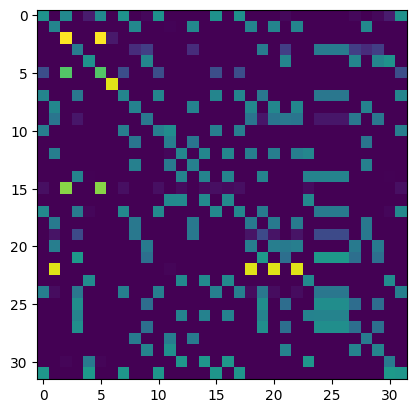

In [586]:
sample = next(iterator)
print(sample[1][:4,:])
print(sample[0][:4,:])

g_repr, l_repr, outer = networks.l_network.apply(trained_learner_state.q_params, sample[1][:32,:], sample[0][:32,:])

dummy_obs = np.zeros((32, obs_dim))
dummy_obs[:,-2:] = sample[1][:32,:]

# outer = g_repr @ l_repr.T
plt.imshow(np.exp(outer))

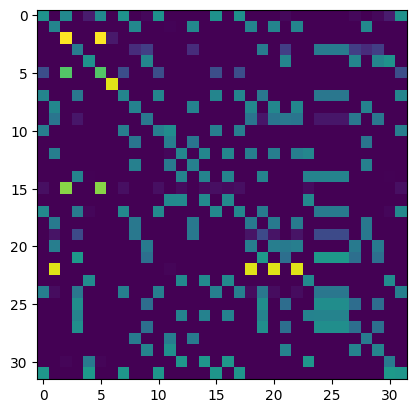

In [587]:
_, g_repr, _ = networks.repr_fn(trained_learner_state.q_params, dummy_obs, np.zeros((32,action_dim)))

# outer = g_repr @ l_repr.T
plt.imshow(np.exp(outer))

In [588]:
import jax.numpy as jnp

def l_loss(l_params, 
          l_data):
    language, goal = l_data
    batch_size = language.shape[0]

    I = jnp.eye(batch_size)  # pylint: disable=invalid-name
    _, _, logits = networks.l_network.apply(l_params, goal, language)

    def loss_fn(_logits):  # pylint: disable=invalid-name
        if config.use_cpc:
            return (optax.softmax_cross_entropy(logits=_logits, labels=I)
                  + 0.01 * jax.nn.logsumexp(_logits, axis=1)**2)
        else:
            return optax.sigmoid_binary_cross_entropy(logits=_logits, labels=I)

    loss = loss_fn(logits)
    loss = jnp.mean(loss)

    # correct = (jnp.argmax(logits, axis=1) == jnp.argmax(I, axis=1))
    # logits_pos = jnp.sum(logits * I) / jnp.sum(I)
    # logits_neg = jnp.sum(logits * (1 - I)) / jnp.sum(1 - I)

    return loss

In [589]:
# sanity check
loss = l_loss(trained_learner_state.q_params, next(iterator))

print(f'LOSS: {loss}')

obs_dim

LOSS: 0.004276360385119915


31

(20, 20)
[[ 0.30265653  0.10788638  0.41921324 -0.4134728  -0.08780643  0.25554508
  -0.46024182  0.04696933  0.38245833  1.2423086   0.34155673  0.86640966
   0.11014479  0.17211872  0.34633878  0.47445208 -0.12792376 -0.12950838
   0.30622745 -0.00766178  0.69015115  0.03584637 -0.6380462   0.29545537
   0.1340377   0.0072005   0.14252415 -0.17772974 -0.31378084 -0.04644775
   0.32221016 -0.27055204  0.7194926  -0.21022063 -0.32364514 -0.09258062
  -0.45423335 -0.560583   -0.22128099  0.08667861 -0.29162866  0.09132791
  -0.5499714   0.18045314 -0.48853523  0.10163698 -0.12068714  0.34873638
   0.26246372  0.32310507 -0.56181645  0.5224315  -1.4353205  -0.49574465
  -0.10286414  0.04968549 -0.6698041   0.2929174  -0.04831849  0.30833572
   0.07802349 -0.28892863  0.14716882  0.1565412 ]]


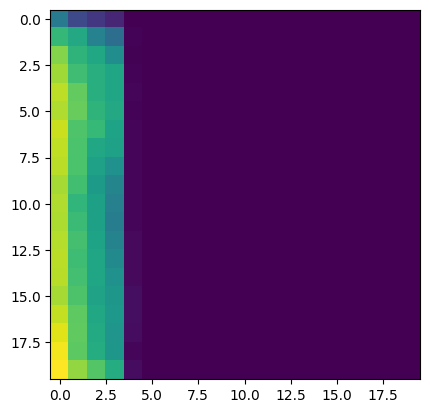

In [590]:
def get_maze(env_name):
    maze = None
    scaling_factor = 1.
    
    if 'ant_' in env_name:
        if 'ant_umaze' in env_name:
            maze = ant_env.U_MAZE
        elif 'ant_medium' in env_name:
            maze = ant_env.BIG_MAZE
        else:
            maze = ant_env.HARDEST_MAZE
        scaling_factor = 4.

  
    if 'point_' in env_name:
        name = env_name[6:]
        maze = point_env.WALLS[name]
        scaling_factor = 1.
      
    maze = np.array(maze)
    return maze

def visualize_language_activation(env_name, category):
    maze = get_maze(env_name)
    activations = np.zeros(np.array(maze.shape) * sf)
    print(activations.shape)
    
    valid_indices = np.argwhere(maze != 1)
    
    one_hot = np.zeros(np.sum(maze_shape))
    one_hot[category] = 1
    one_hot = one_hot[None,:]
    _, l_repr, _ = networks.l_network.apply(trained_learner_state.q_params, np.zeros((1, 2)), one_hot)
    print(l_repr)
    # print(l_repr @ )
    
    
    scaled_rows = maze.shape[0] * sf
    scaled_cols = maze.shape[1] * sf
    for i in range(scaled_rows):
        for j in range(scaled_cols):
            if maze[i // sf,j // sf] == 1:
                continue
            
            N = 100
            rand2d = np.array([[i, j]]) + np.random.uniform(0, 1, (N, 2))
            obs = np.zeros((N, obs_dim))
            obs[:,-2:] = rand2d
            # print(obs)
            _, g_repr, (s, g) = networks.repr_fn(q_params, obs=obs, action=np.zeros((N, action_dim)))
            # print(s)
            activations[i, j] = np.mean(np.exp(l_repr @ g_repr.T))
    
    return activations

acts = visualize_language_activation(env_name, 5)
plt.imshow(acts)

In [591]:
obs.shape

(1, 31)

In [592]:
def sample_goals(env_name, num_goals=10):
    maze = get_maze(env_name)
    
    valid_indices = np.argwhere(maze != 1)
    
    rand_noise = np.random.uniform(0, 1, (num_goals, 2))
    rand_index = np.random.randint(0, len(valid_indices), (num_goals,))
    point = valid_indices[rand_index] + rand_noise
    
    return point * sf

sample_goals(env_name, 10)

array([[12.85188086,  7.8645334 ],
       [ 8.70490656,  2.80129883],
       [14.48253602,  0.90119755],
       [13.89562964, 13.21282423],
       [10.31185677,  2.16412558],
       [14.59150128, 10.45253169],
       [19.98815627, 13.86623508],
       [14.63787726, 11.19621529],
       [17.97672631,  3.22218208],
       [19.96186698, 19.1668916 ]])

In [593]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory(points, goal):
    plt.figure(figsize=(10, 10))
    start = points[0]
    end = points[-1]
    
    # Plot the trajectory
    points = np.array(points)
    plt.plot(points[:,0], points[:,1], 'b-', alpha=0.5, linewidth=1)
    
    # Plot all trajectory points (smaller and more transparent)
    plt.scatter(points[:,0], points[:,1], color='blue', s=10, alpha=0.3)
    
    # Plot goal point
    plt.scatter(goal[0], goal[1], color='purple', s=100, label='Goal', zorder=3)
    
    # Plot start point (above trajectory)
    plt.scatter(start[0], start[1], color='green', s=100, label='Start', zorder=4)
    
    # Plot end point (above trajectory)
    plt.scatter(end[0], end[1], color='red', s=100, label='End', zorder=4)
    
    plt.xlim((-0.5, 21.))
    plt.ylim((-0.5, 21.))
    plt.legend()
    plt.title('Agent Trajectory')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.show()

# Usage:
# plot_trajectory(points, goal)

def grid_search_action(env, networks, q_params, obs, num_samples=5, category=None, LSE=True, LSE_dim=1000):
    random_states = sample_goals(env_name, num_goals=num_samples)
    
    #print(f'obs: {obs.shape}')
    obs_random_goals = np.tile(obs, (num_samples, 1))
    obs_random_goals[:,-2:] = random_states
    #print(obs_random_goals.shape)
    
    dist = networks.policy_network.apply(
          trained_learner_state.policy_params,
          obs_random_goals
        )
    action_grid = np.array(dist.mode())
    # print(f'actions: {action_grid}')

    # print(action_grid)
    best_action = None
    best_dot_product = -np.inf
    
    # compute goal representation
    if category:
        one_hot = np.zeros(np.sum(maze_shape))
        one_hot[category] = 1
        one_hot = one_hot[None,:]
        _, g_repr, _ = networks.l_network.apply(trained_learner_state.q_params, np.zeros((1, 2)), one_hot)
    else:
        _, g_repr, _ = networks.repr_fn(q_params, obs=obs, action=np.zeros((1, action_dim)))

    # compute set of intermediate representations
    
    if category and LSE:
        dummy_obs = np.zeros(obs.shape)
        # print(dummy_obs.shape)
        dummy_obs = np.tile(dummy_obs, (LSE_dim, 1))
        # print(f'dummy obs shape: {dummy_obs.shape}')
        intermed_states = sample_goals(env_name, num_goals=LSE_dim)
        # print(f'intermed_states shapes: {intermed_states.shape}')
        dummy_obs[:,-2:] = intermed_states
        # print(dummy_obs)
        _, i_reprs1, _ = networks.repr_fn(q_params, obs=dummy_obs, action=np.zeros((LSE_dim, action_dim)))
        i_reprs2, _, _ = networks.l_network.apply(trained_learner_state.q_params, 
                                                    intermed_states, np.zeros((LSE_dim, np.sum(maze_shape))))
        # print(i_reprs.shape) # LSE_dim x repr_dim
    # pass through network now to get representations
    
    
    for action in action_grid:
        # Compute representations
        action = np.array(action, dtype=np.float32)
        sa_repr, _, _ = networks.repr_fn(q_params, obs=obs, action=action[None, :])
        
        if category and LSE:
            p_sas = sa_repr @ i_reprs1.T
            p_ls = g_repr @ i_reprs2.T

            p_tot = p_sas + p_ls
            exp_tot = np.exp(p_tot)
            # print(f'exp_tot: {exp_tot.shape}')
            dot_product = np.mean(exp_tot)
        else:
            dot_product = np.dot(sa_repr.flatten(), g_repr.flatten())

        if dot_product > best_dot_product:
            best_dot_product = dot_product
            best_action = action

    # Step the environment with the best action
    transition = env.step(best_action)

    return best_action

def run_episode(env, networks, q_params, n_steps=1, num_samples=1, categorical=False, LSE=True):
    obs = env.reset().observation[None,:]
    
    category=None
    if categorical:
        category = np.random.randint(0, np.sum(maze_shape))
    
    
    total_reward = 0
    done = False
    
    print(f'start: {obs[0,:2]}, goal: {obs[0,-2:]}')
    

    points = []
    for step in tqdm(range(n_steps)):
#         print(f"\nStep {step + 1}/{n_steps}")
#         print(f"Current observation: {obs[:,:2]}, Goal: {obs[:,-2:]}")
        
        if DEBUG:
            dist = networks.policy_network.apply(
                      trained_learner_state.policy_params,
                      obs
                    )
            best_action = np.array(dist.mode())[0]
        else:
            best_action = grid_search_action(env, 
                                            networks, 
                                            q_params, 
                                            obs, 
                                            num_samples, 
                                            category=category,
                                            LSE=LSE
                                           )
        
        transition = env.step(best_action)
        obs = transition.observation[None,:]
        # print(obs[:,:2])
        points.append(obs[0,:2])
        
        cur = obs[0,:2]
        goal = obs[0,-2:]
        
        
        if categorical:
            # print(f'category: {category} and position: {cur}')
            cond1 = category < maze_shape[0] and category == int(cur[0] / sf)
            cond2 = category >= maze_shape[0] and category == (int(cur[1] / sf) + maze_shape[0])
            if cond1 or cond2:
                done = True
                break
        else:
            if np.linalg.norm(cur - goal) < 1.0:
                done= True
                break
        
    print(f'end state: {cur}, category: {category}')
    # plot_trajectory(points, goal)
    return done


In [594]:
DEBUG = True
# Example usage:
NUM_TRIALS = 10
success_rate = 0
for i in range(NUM_TRIALS):
    done = run_episode(env, 
                       networks, 
                       q_params,
                       n_steps=700, 
                       num_samples=100, 
                       categorical=False,
                       LSE=False
                      )
    success_rate += done
print(f'success: {success_rate / NUM_TRIALS}')

new goal: (9.32182937659, 0.4841573575030551)
start: [0.5786974  0.41188368], goal: [8.501244   0.47686878]


100%|██████████| 700/700 [00:11<00:00, 62.32it/s]


end state: [ 6.687186   -0.57518464], category: None
new goal: (4.307803250731139, 8.705618899232373)
start: [0.18589102 0.93997407], goal: [3.9612718 8.709267 ]


100%|██████████| 700/700 [00:11<00:00, 61.92it/s]


end state: [ 3.5914502  -0.04451904], category: None
new goal: (9.15254248351639, 0.7112602996655664)
start: [4.654885 8.669876], goal: [9.226067   0.84332377]


100%|██████████| 700/700 [00:11<00:00, 62.12it/s]


end state: [6.781319  7.4479656], category: None
new goal: (8.30977489346625, 5.061326544704971)
start: [4.345977  1.2875662], goal: [8.307778  5.0566726]


100%|██████████| 700/700 [00:11<00:00, 61.87it/s]


end state: [4.860401  1.0522888], category: None
new goal: (8.791784001315188, 0.7574109214091389)
start: [4.828958 9.441061], goal: [8.64172   0.8638058]


100%|██████████| 700/700 [00:11<00:00, 60.11it/s]


end state: [8.534533 4.408674], category: None
new goal: (9.01187041263625, 4.3533142295972205)
start: [0.6221473  0.36025968], goal: [8.924643  4.5057898]


100%|██████████| 700/700 [00:11<00:00, 59.80it/s]


end state: [ 5.1556     -0.23598833], category: None
new goal: (8.542186470958589, 8.429773447663004)
start: [0.30893672 0.09864844], goal: [8.687565 8.422136]


100%|██████████| 700/700 [00:11<00:00, 62.03it/s]


end state: [ 3.7863765  -0.30230996], category: None
new goal: (8.34347690098386, 1.0602763504203954)
start: [0.9042305  0.06711199], goal: [8.295922   0.85658497]


100%|██████████| 700/700 [00:11<00:00, 61.94it/s]


end state: [ 2.469294  -1.2759562], category: None
new goal: (0.8297804301338593, 9.045698794827308)
start: [0.7226399 8.60092  ], goal: [0.7742811 8.829839 ]


  0%|          | 0/700 [00:00<?, ?it/s]


end state: [0.7101726 8.592002 ], category: None
new goal: (0.32702270604000355, 8.261826394376902)
start: [0.8190595 0.5361288], goal: [0.37533325 8.098371  ]


100%|██████████| 700/700 [00:11<00:00, 61.95it/s]

end state: [0.43653697 0.1430139 ], category: None
success: 0.1


In [595]:

DEBUG = False
# Example usage:
NUM_TRIALS = 10
success_rate = 0
for i in range(NUM_TRIALS):
    done = run_episode(env, 
                       networks, 
                       q_params, 
                       n_steps=100, 
                       num_samples=100, 
                       categorical=True,
                       LSE=True
                      )
    success_rate += done
print(f'success: {success_rate / NUM_TRIALS}')

new goal: (8.370459676761959, 1.021575809459827)
start: [8.931455 8.117456], goal: [8.551589  1.1554781]


 81%|████████  | 81/100 [00:40<00:09,  1.99it/s]


end state: [7.912205  6.8036847], category: 1
new goal: (8.770291397224964, 0.3546528693933632)
start: [0.44803998 0.46192607], goal: [8.868793   0.21629325]


  0%|          | 0/100 [00:00<?, ?it/s]


end state: [0.5055559  0.44733042], category: 5
new goal: (5.000531558394639, 8.955052909337146)
start: [0.7954524  0.85646784], goal: [5.0066867 8.85885  ]


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


end state: [ 5.0838995  -0.06988744], category: 8
new goal: (8.721768902413663, 5.052480114978838)
start: [0.73413205 0.36782104], goal: [8.686329 5.148192]


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


end state: [1.6933589  0.24319953], category: 8
new goal: (9.15857858771967, 0.5733099492891918)
start: [1.120854 8.658637], goal: [8.925565   0.62239254]


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


end state: [-0.31340522  8.615816  ], category: 6
new goal: (4.835625126074777, 1.0485931106244193)
start: [0.3750101  0.01718355], goal: [4.7610464 1.1752667]


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


end state: [3.5395424  0.43573397], category: 8
new goal: (4.140093871764778, 9.350148613922643)
start: [4.5593824 0.6766684], goal: [4.2639704 8.7702265]


  0%|          | 0/100 [00:00<?, ?it/s]


end state: [4.6336856 0.6607757], category: 5
new goal: (8.641954229584858, 9.295572589147001)
start: [0.6917359 0.7743714], goal: [8.519844 8.173057]


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


end state: [0.7616265  0.42041734], category: 3
new goal: (9.104847371677865, 4.846205552570744)
start: [8.699959   0.44686326], goal: [9.145989  4.7502093]


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


end state: [8.567002  1.5783038], category: 9
new goal: (5.244949044694624, 8.631266907995805)
start: [0.49536553 8.406304  ], goal: [5.449949 8.515116]


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

end state: [0.8830184 9.057746 ], category: 2
success: 0.3


In [596]:
DEBUG = False
# Example usage:
NUM_TRIALS = 10
success_rate = 0
for i in range(NUM_TRIALS):
    done = run_episode(env, 
                       networks, 
                       q_params, 
                       n_steps=100, 
                       num_samples=100, 
                       categorical=True,
                       LSE=False
                      )
    success_rate += done
print(f'success: {success_rate / NUM_TRIALS}')

new goal: (5.0468660633330895, 0.977730571722234)
start: [0.53610873 0.72766006], goal: [4.922506  1.0032237]


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


end state: [2.204548  0.7379682], category: 6
new goal: (4.912668854608478, 0.8285878029027085)
start: [0.17081071 0.6541181 ], goal: [4.7633142 0.8112528]


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


end state: [3.1561365 0.5877366], category: 8
new goal: (1.034687317207361, 9.058138948300126)
start: [0.18447031 0.06717885], goal: [0.9882493 8.906193 ]


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


end state: [0.49054876 0.3725748 ], category: 3
new goal: (4.427668543243051, 0.7749648579645729)
start: [0.2657243  0.97333264], goal: [4.622106   0.74413365]


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


end state: [3.1548324  0.08104862], category: 6
new goal: (9.077446427863842, 8.332599004534336)
start: [5.0881553  0.24549165], goal: [9.061455 8.318594]


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


end state: [ 5.6262503  -0.46788234], category: 2
new goal: (9.072696291789239, 8.661355663530367)
start: [0.7501887  0.76733035], goal: [9.105452 8.669905]


  0%|          | 0/100 [00:00<?, ?it/s]


end state: [0.76733816 0.743773  ], category: 0
new goal: (4.999217874984193, 9.039125837935568)
start: [4.272714 0.753308], goal: [5.116929 8.843666]


  0%|          | 0/100 [00:00<?, ?it/s]


end state: [4.220143  0.7624699], category: 1
new goal: (0.6590987559311925, 8.098974423201401)
start: [8.467396   0.25683612], goal: [0.65991896 8.312759  ]


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


end state: [ 8.909768  -0.8716178], category: 6
new goal: (9.070535008879238, 0.6521603044274293)
start: [8.325247 8.928783], goal: [9.065469 0.422851]


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


end state: [7.5914307 8.620904 ], category: 5
new goal: (8.801145525278384, 0.9398043810028086)
start: [0.94511694 0.9457109 ], goal: [8.973198   0.94478506]


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]

end state: [0.689865   0.88487965], category: 2
success: 0.2


In [ ]:
p = np.array(points)
plt.scatter(p[:,0], p[:,1])

In [ ]:
p.shape

In [ ]:
sa_repr, g_repr, (state, goal) = networks.repr_fn(q_params, obs=obs, action=action)

In [ ]:
NUM_EPISODES = 25

env = env_factory(np.random.randint(1e6))
obs_dim = env.observation_spec().shape[0] // 2
episode_returns = np.zeros([NUM_EPISODES, ])

timesteps = []
for epi in range(NUM_EPISODES):
    t = 0
    env.seed(epi)  # use fixed seed for different methods
    timestep = env.reset()
    episode_return = 0
    
    # print(f'start state: {timestep.observation[:2]}, goal: {timestep.observation[-2:]}')
    # goal = [5.9277008955091254, 8.699144684746049]

    while not timestep.last():
        obs = timestep.observation
        # print(obs.shape)
        # obs[-2:] = goal
        dist = networks.policy_network.apply(
          trained_learner_state.policy_params,
          timestep.observation
        )
        action = np.array(dist.mode())
        # print(action)
        timestep = env.step(action)
        timesteps.append(timestep)

        # Book-keeping.
        t += 1
        episode_return += timestep.reward

    # assert t == env._step_limit
    # print("episode length = {}".format(t))
    episode_returns[epi] = episode_return

print("avg episode return: {}".format(np.mean(episode_returns)))
print("success rate: {}".format(np.mean(episode_returns >= 1)))

In [ ]:
points = []
for timestep in timesteps:
    points.append(timestep.observation[:2])
    
points = np.array(points)
plt.scatter(points[:,0], points[:,1])

In [ ]:
points